In [1]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from scipy.special import expit
from sklearn import linear_model, metrics
from sklearn.metrics import auc, plot_roc_curve, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from mapra import prep

sns.set_theme(style='white')


def save(fig, path):
    wd = Path('.').resolve().parent / 'plots'
    Path.mkdir((wd / path).parent, parents=True, exist_ok=True)
    fig.savefig(wd / path, dpi=300, bbox_inches='tight', pad_inches=.1)

cosine similarity
multiply the cosines distances

or feed both values into an NN

In [2]:
importlib.reload(prep)
data = prep.dataset()
npr = data.fetch_numpy_distances()
delta_labels = data.order
'''
The first column indicates the metric,
the second the value,
the rest is the embedding diff
'''

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:37: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)


loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl


'\nThe first column indicates the metric,\nthe second the value,\nthe rest is the embedding diff\n'

In [3]:
# _abs= '_abs'
# npr[:, 1] = abs(npr[:, 1])
_abs = ''

In [4]:
spears = dict()
for i, delta in enumerate(delta_labels):
    # select only matching rows, and ignore the delta column
    dnpr = npr[npr[:, 0] == i, 1:]
    spear, pval = scipy.stats.spearmanr(dnpr, axis=0)
    # only need first line[1:] of output matrix
    spears[delta] = spear[0, 1:]
spears

{'dtemp': array([ 0.11917816,  0.08558531,  0.15808247, ..., -0.0420155 ,
         0.04407386, -0.07219054]),
 'ddg': array([ 0.02027241,  0.04867881,  0.21048373, ..., -0.01711015,
        -0.01872658, -0.07774655]),
 'h2o': array([ 0.09248193,  0.19152187,  0.22394765, ..., -0.0162556 ,
         0.10900918, -0.13531456])}

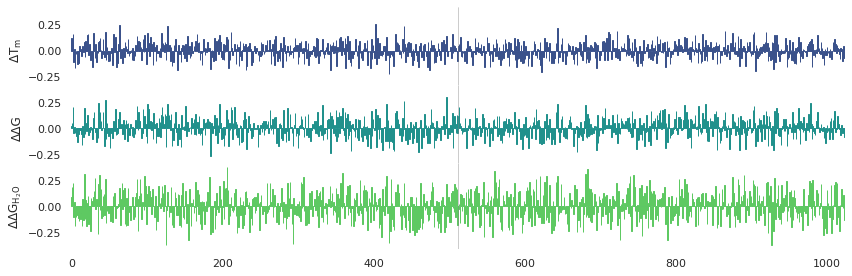

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)
for ax, (delta, spear_row), color in zip(
        axes, spears.items(), sns.color_palette('viridis', 3)):
    ax.axvline(x=512, lw=.5, color='.5', alpha=.8)
    ax.bar(x=list(range(1024)), height=spear_row,
           edgecolor=color, label=delta)
ax.set_xlim(-1, 1024)

for delta, ax in zip(delta_labels, axes.flatten()):
    ax.set(ylabel=data.tex_lookup[delta], xlabel='')

axes[2].set(xticks=[i for i in range(1024) if not i % 200])
sns.despine(fig, left=True, bottom=True)
fig.tight_layout()
fig.subplots_adjust(hspace=-.1)

save(fig, f'spearman_cor_h5_matplotlib{_abs}.png')

In [6]:
spd = pd.DataFrame()
spd['x'] = range(1024)

for i, delta in enumerate(delta_labels):
    # select only matching rows, and ignore the delta column
    dnpr = npr[npr[:, 0] == i, 1:]
    spear, pval = scipy.stats.spearmanr(dnpr, axis=0)
    # only need first line[1:] of output matrix
    spd[delta] = spear[0, 1:]

In [7]:
corr_corr = spd.loc[:, delta_labels].corr(method='spearman')
corr_corr

,dtemp,ddg,h2o
dtemp,1.000000,0.768764,0.444120
ddg,0.768764,1.000000,0.530728
h2o,0.444120,0.530728,1.000000


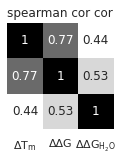

In [8]:
f, ax = plt.subplots(1, 1, figsize=(2.4, 2.4))
labs = [data.tex_lookup[delta] for delta in delta_labels]
g = sns.heatmap(corr_corr, annot=True, cmap='binary', cbar=False, square=True, ax=ax,
                xticklabels=labs, yticklabels=False)
g.set(title='spearman cor cor')
f.tight_layout()
save(f, f'spearman_cor_cor{_abs}.png')

In [9]:
spd = spd.melt(id_vars='x', var_name='delta', value_name='y')
spd


,x,delta,y
0,0,dtemp,0.119178
1,1,dtemp,0.085585
2,2,dtemp,0.158082
3,3,dtemp,-0.108385
4,4,dtemp,0.011450
...,...,...,...
3067,1019,h2o,0.172391
3068,1020,h2o,0.019401
3069,1021,h2o,-0.016256
3070,1022,h2o,0.109009


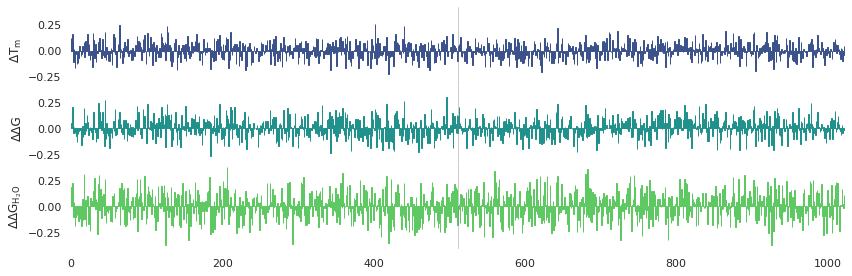

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)
for ax, delta, color in zip(
        axes, delta_labels, sns.color_palette('viridis', 3)):
    ax.axvline(x=512, lw=.5, color='.5', alpha=.8)
    sns.barplot(data=spd.loc[spd.delta == delta],
                x='x', y='y', ax=ax,
                facecolor=color,
                linewidth=1, edgecolor=color)
for delta, ax in zip(delta_labels, axes.flatten()):
    ax.set(ylabel=data.tex_lookup[delta], xlabel='')

axes[2].set(xticks=[i for i in range(1024) if not i % 200])
sns.despine(fig, left=True, bottom=True)
fig.tight_layout()
fig.subplots_adjust(hspace=-.1)

save(fig, f'spearman_cor_h5{_abs}.png')

### Try predicting from the vector length, maybe that's better than adding up pairwise distances

In [11]:
sns.set_theme(style='white')

# use all that stuff from the 4b_logit notebook
extend = 0
func = sum
modify = 'abs'
metric = 'euclidean'
thresholds = [3, 1, 1.5]
# even the old dataframe
mbeds = data.fetch_df_with_pairwise_distances(extend=extend, modify=modify, func=func)
# metric = 'euclidean'
df = mbeds.data.loc[(mbeds.data.metric == mbeds.metric_labels.index(metric)),
                    [c for c in mbeds.data.columns if c != 'metric']]
df

loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl


,delta,dist,change
0,0,6.147786,9.9
1,0,4.140685,2.3
2,0,3.226287,3.6
3,0,3.282363,1.0
4,0,11.105935,5.6
...,...,...,...
26158,2,3.403326,0.6
26159,2,3.403326,1.1
26160,2,3.717135,0.9
26161,2,3.717135,1.1


In [12]:
# but replace the sum of pqirwise dists with the diff sum vector length
df.dist = np.linalg.norm(npr[:, 2:], axis=1)
df

,delta,dist,change
0,0,6.148438,9.9
1,0,4.140625,2.3
2,0,3.226562,3.6
3,0,3.283203,1.0
4,0,6.476562,5.6
...,...,...,...
26158,2,3.404297,0.6
26159,2,3.404297,1.1
26160,2,3.716797,0.9
26161,2,3.716797,1.1


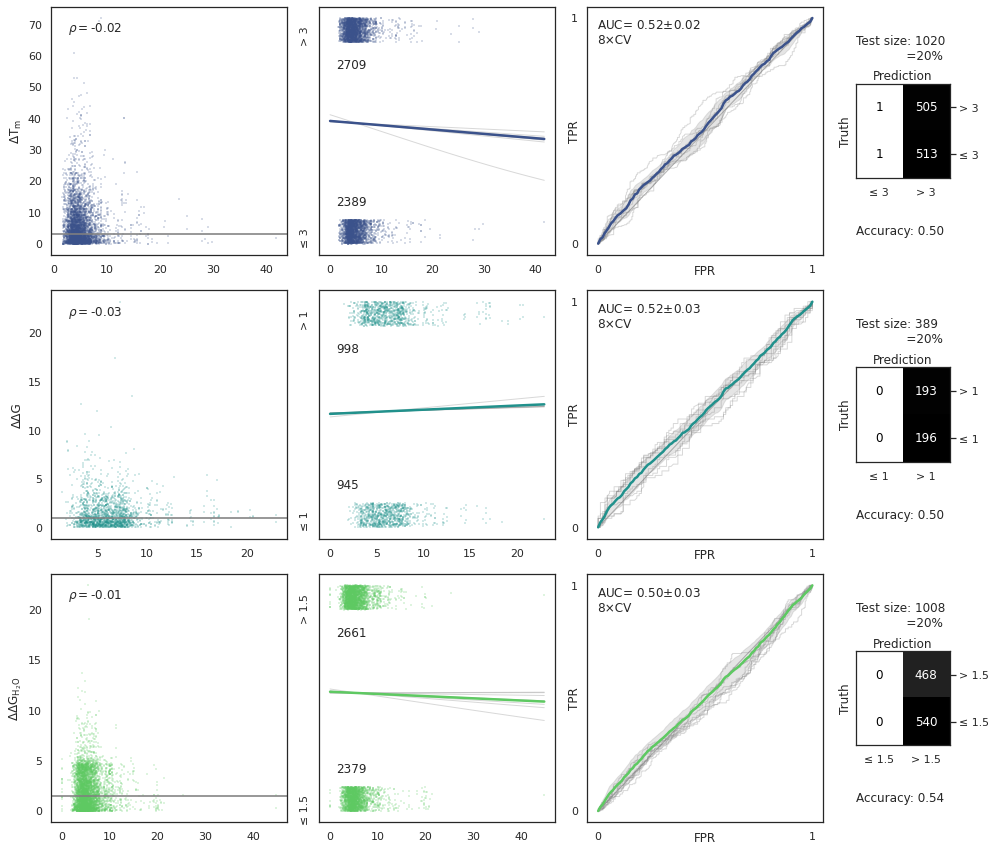

In [13]:
# # create class labels
# thresholds = [3, 1, 1.5]
df['label'] = df.apply(lambda gdf: 0 if abs(gdf.change) <= thresholds[int(gdf.delta)] else 1, axis=1)

# plotting prep
fig, axs = plt.subplots(3, 4, figsize=(14, 12), gridspec_kw={'width_ratios': [1, 1, 1, .4]})
cmap = sns.color_palette('viridis', 3)
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = list(), list()
test_size = .2

for i, delta in enumerate(mbeds.delta_labels):
    # select the records for this delta
    dfn = df.loc[df.delta == i]

    sns.regplot(data=dfn,
                ax=axs[i, 0],
                x='dist', y='change',
                color=cmap[i],
                marker='+',
                scatter_kws={'s': 3, 'alpha': .2},
                fit_reg=False, logistic=True)
    axs[i, 0].set(ylabel=data.tex_lookup[delta], xlabel='')
    axs[i, 0].axhline(y=thresholds[i], lw=2, color='.5', alpha=.8)

    # make the scatterplot
    sns.regplot(data=dfn,
                ax=axs[i, 1],
                x='dist', y='label',
                marker='+',
                y_jitter=.06, color=cmap[i],
                scatter_kws={'s': 3, 'alpha': .2},
                fit_reg=False, logistic=True)
    axs[i, 1].set(xlabel='', yticks=[0, 1], ylabel='',
                  yticklabels=[f'≤ {thresholds[i]}', f'> {thresholds[i]}'])
    axs[i, 1].tick_params(axis='y', labelrotation=90)
    axs[i, 1].yaxis.labelpad = -10

    # fetch the training data
    X, y = np.array(dfn['dist']).reshape(-1, 1), np.array(dfn['label'])

    # split into test and training data
    X, x_test, y, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)

    n_splits = 8
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    clf = linear_model.LogisticRegressionCV(random_state=42,
                                            cv=cv,  # use existing splitter
                                            refit=True)  # build best model in the end

    for j, (train, test) in enumerate(cv.split(X, y)):
        clf.fit(X[train], y[train])

        # plot a ROC curve
        viz = plot_roc_curve(clf, X[test], y[test], lw=1, color='.5', alpha=.3, ax=axs[i, 2])
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        # plot the loss curves
        x_line = np.linspace(0, max(X), 100)
        loss = expit(x_line * clf.coef_ + clf.intercept_).ravel()
        axs[i, 1].plot(x_line, loss, lw=1, color='.5', alpha=.3)

    # correlations
    pearson_corr = np.corrcoef(dfn[['dist', 'change']], rowvar=False)[0, 1]
    spearman_corr, pval = scipy.stats.spearmanr(dfn[['dist', 'change']], axis=0)
    axs[i, 0].text(.07, .9, r'$\rho = $' + f'{spearman_corr:.2f}', transform=axs[i, 0].transAxes)

    # label class sizes
    axs[i, 1].text(.07, .75, f'{len(dfn.loc[dfn.label == 1]):.0f}', transform=axs[i, 1].transAxes)
    axs[i, 1].text(.07, .20, f'{len(dfn.loc[dfn.label == 0]):.0f}', transform=axs[i, 1].transAxes)

    # plot the overall loss curve
    x_line = np.linspace(0, max(X), 100)
    loss = expit(x_line * clf.coef_ + clf.intercept_).ravel()
    axs[i, 1].plot(x_line, loss, lw=2.5, color=cmap[i], alpha=1)

    # plot the diagonal
    axs[i, 2].plot([0, 1], [0, 1], lw=1, color='.5', alpha=.6)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    axs[i, 2].plot(mean_fpr, mean_tpr, color=cmap[i], lw=2.5, alpha=1)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    axs[i, 2].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

    axs[i, 2].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])  #, title="Receiver operating characteristic example")
    axs[i, 2].text(.04, .85, f'AUC= {mean_auc:0.2f}$\pm${std_auc:.2f}\n{n_splits}×CV', transform=axs[i, 2].transAxes)
    axs[i, 2].get_legend().remove()
    axs[i, 2].set(xlabel='FPR', ylabel='TPR', xticks=[0, 1], yticks=[0, 1])
    axs[i, 2].xaxis.labelpad = -10
    axs[i, 2].yaxis.labelpad = -10

    # make final test
    f = metrics.plot_confusion_matrix(clf, x_test, y_test, ax=axs[i, 3],
                                      cmap='binary', colorbar=False)
    axs[i, 3].yaxis.tick_right()
    axs[i, 3].xaxis.set_label_position('top')

    axs[i, 3].set(ylabel='Truth', xlabel='Prediction',
                  xticklabels=[f'≤ {thresholds[i]}', f'> {thresholds[i]}'],
                  yticklabels=[f'≤ {thresholds[i]}', f'> {thresholds[i]}'][::-1])

    axs[i, 3].text(0, 1.1, f'Test size: {len(x_test)}\n             ={test_size * 100:.0f}%\n',
                   transform=axs[i, 3].transAxes)
    axs[i, 3].text(0, -.6, f'Accuracy: {clf.score(x_test, y_test):.2f}',
                   transform=axs[i, 3].transAxes)

wd = Path('.').resolve().parent / 'plots' / 'comp'
Path.mkdir(wd, parents=True, exist_ok=True)
fig.tight_layout()
fig.savefig(
    wd / f'df_numpy_dist_euclidean_{1 + 2 * extend}_{modify}_{func.__name__}_{"-".join([str(t) for t in thresholds])}.png',
    dpi=300, bbox_inches=0)


In [14]:
npr


array([[ 0.0000e+00,  9.8984e+00, -9.8877e-02, ...,  2.8412e-02,
         3.3936e-02,  5.3711e-03],
       [ 0.0000e+00,  2.3008e+00,  1.5015e-02, ..., -3.9917e-02,
        -1.0040e-01, -1.1914e-01],
       [ 0.0000e+00,  3.5996e+00, -7.5806e-02, ...,  1.4893e-02,
        -1.6138e-01,  6.3477e-02],
       ...,
       [ 2.0000e+00, -8.9990e-01, -1.3513e-01, ..., -3.2227e-02,
        -1.0156e-01,  1.6956e-01],
       [ 2.0000e+00, -1.0996e+00, -1.3513e-01, ..., -3.2227e-02,
        -1.0156e-01,  1.6956e-01],
       [ 2.0000e+00,  9.9976e-02, -1.3513e-01, ..., -3.2227e-02,
        -1.0156e-01,  1.6956e-01]], dtype=float16)

### multiple linear regression / multivariate logistic regression

In [15]:
ars = list()
models = list()
for i, delta in enumerate(delta_labels):
    # select the rows for this delta, and cleave off the delta column
    dnpr = npr[npr[:, 0] == i, 1:]
    print(dnpr.shape)

    # split into features and labels
    X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

    # split into test and training data
    test_size = .2
    X, X_test, y, y_true = train_test_split(
        X, y, test_size=test_size)  #, random_state=32)
    # X, X_test, y, y_true = X, X, y, y

    regr = linear_model.LinearRegression()
    regr.fit(X, y)

    # make a prediction
    y_pred = regr.predict(X_test)

    # save
    ars.append(np.hstack((np.full(y_pred.shape, i), y_pred, y_true)))
    models.append(regr)

ars

(5098, 1025)
(1943, 1025)
(5040, 1025)


[array([[  0.        ,  -3.66530323,  -5.5       ],
        [  0.        , -13.02015591,  -2.90039062],
        [  0.        ,  -9.55224705,  16.40625   ],
        ...,
        [  0.        ,   9.22221756,   3.36914062],
        [  0.        ,  -3.98832846,  -6.1015625 ],
        [  0.        ,   1.45552766,   4.30078125]]),
 array([[ 1.        , -3.02022123, -1.09960938],
        [ 1.        ,  0.38459587,  0.26000977],
        [ 1.        , -1.55362606, -1.59960938],
        ...,
        [ 1.        ,  3.66986227,  2.80078125],
        [ 1.        ,  1.90635061,  1.        ],
        [ 1.        ,  0.26132298, -0.91992188]]),
 array([[ 2.        , -2.1127789 , -0.07000732],
        [ 2.        , -0.00708866, -2.09960938],
        [ 2.        , -2.03626585, -2.        ],
        ...,
        [ 2.        , -1.99905825, -2.15039062],
        [ 2.        , -0.92279482,  0.09997559],
        [ 2.        ,  0.66618013, -0.05999756]])]

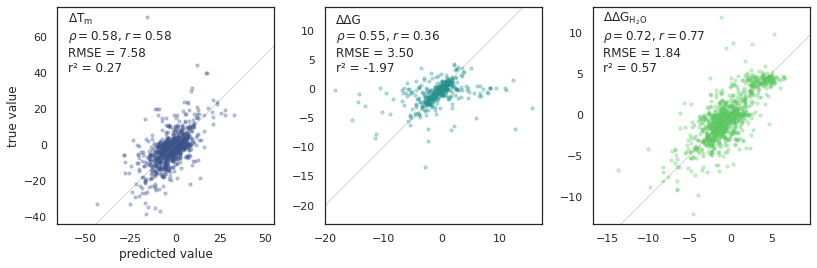

In [16]:
# plot with matplotlib
fig, axes = plt.subplots(1, 3, figsize=(13.6, 4))
cmap = sns.color_palette('viridis', 3)

for i, (ax, ar, delta) in enumerate(zip(axes, ars, delta_labels)):
    sns.regplot(ax=axes[i],
                x=ar[:, 1], y=ar[:, 2],
                color=cmap[i],
                # marker='+',
                scatter_kws={'s': 10, 'alpha': .3},
                fit_reg=False, logistic=True)

    ax.set(aspect=1, box_aspect=1)
    # ax.set(title=data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
    ax.axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)

    # correlations
    sp, pval = scipy.stats.spearmanr(ar[:, 1:], axis=0)
    pcorr = np.corrcoef(ar[:, 1:], rowvar=False)[0, 1]
    rmse =mean_squared_error(ar[:, 2], ar[:, 1], squared=False)
    r2 = r2_score(ar[:, 2], ar[:, 1])

    # ax.text(.05, .82, data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i] + '\n'
    #         + r"Spearman's $\rho = $" + f'{sp:.2f}',
    #         transform=ax.transAxes)
    ax.text(.05, .7, data.tex_lookup[delta] + '\n'
            + r"$\rho = $" + f'{sp:.2f}, ' + r"$r = $" + f'{pcorr:.2f}\nRMSE = {rmse:.2f}\nr² = {r2:.2f}',
            transform=ax.transAxes)

axes[0].set(ylabel='true value', xlabel='predicted value')
save(fig, f'linear_regr_2{_abs}_test_0.2.png')



### this is overfitting
- negative r² for train:test = 8:2 means worse than random
- near-perfect performance for train=test indicates overfit

"decrease the complexity of the model for DDG somehow" -> [Feature selection](https://en.wikipedia.org/wiki/Feature_selection#Filter_method)!!
"Can you establish some kind of random baseline? Maybe use the regression based on the Euclidean distance and calculate the RMSE for that. Your new version should be better, but it would be good to be able to show by how much."


use LogisticRegressionCV to predict a < -1 , -1 <= a <= 1, 1 < a labels

try [PolynomialFeatures](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)

discretize y_test and y_pred to use [MCC](https://scikit-learn.org/stable/modules/model_evaluation.html#matthews-correlation-coefficient)?

[Regression metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

R² score ~ goodness of fit. to compare how well a regression fits to the different metrics, but is not comparable outside of the dataset

compare to a [dummy estimator](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)

use LASSO when there are few important features. However, it looks like we have many meaningful positions? Meaning those with correlations not close to 0.

LinearRegression calculates ordinary least squares

a [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron) is a binary classifier :(
